<a href="https://colab.research.google.com/github/rasecotineb/datascience/blob/master/time-series/ModeloSARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MÉTODOS DE DATA ANALYTICS PARA SERIES TEMPORALES 
Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial

Dr. Edwin Villanueva Talavera (ervillanueva@pucp.edu.pe)

Importa librerias a usar

In [ ]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
plt.rcParams['figure.figsize'] = [10, 8]  #por defecto las figuras se displayan 8 pulgadas de ancho y 6 de alto

# SARIMA

Abajo se presenta un ejemplo de implementacion de modelo SARIMA para la serie <b>airline-passengers.csv</b>. 

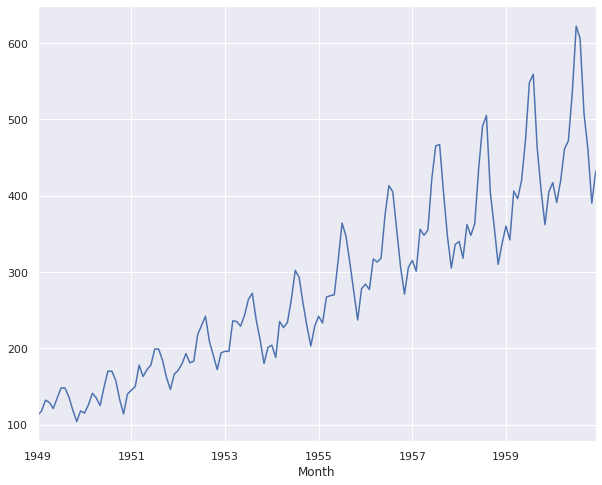

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# carga la serie  airline-passengers


#series = pd.read_csv('airline-passengers.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series = pd.read_csv('https://drive.google.com/uc?id=15WdOVI0iBKP10tKea2nCBPKxXpng0CO6&export=download', header=0, index_col=0, parse_dates=True, squeeze=True)

# plotea la serie
series.plot()
plt.show()


En el plot se puede apreciar una tendencia positiva, estacionalidad, y varianza creciente. Antes de construir algun modelo trataremos de hacer estacionaria la varianza aplicando una transformacion logaritmica y luego  partimos la serie en 70% para entrenamiento y 30% para test.   

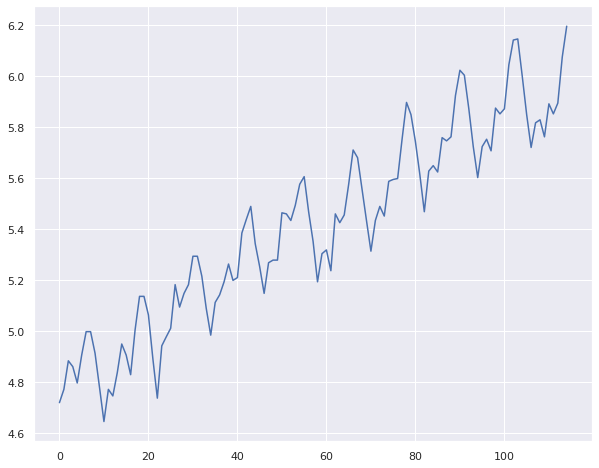

In [ ]:
# saca logaritmo para tratar de hacer estacionaria la varianza de la serie
X = series.values
X = np.log(X)   

# Parte la serie en conjuntos de train/test
size = int(len(X) * 0.80)   # 80% para train,20% para test
train, test = X[0:size], X[size:len(X)]

# Plotea la serie transformada de train 
plt.plot(train)
plt.show()

ahora diferenciamos para ver si se remueve la tendencia y se hace estacionaria

ADF Statistic: -2.635851
p-value: 0.085812
Critical Values:
	1%: -3.497
	5%: -2.891
	10%: -2.582


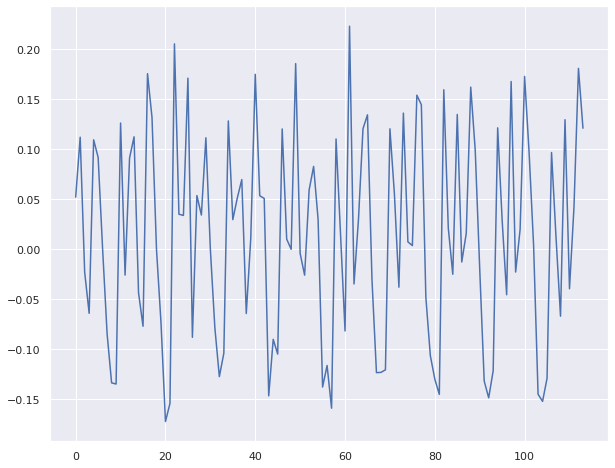

In [ ]:
from statsmodels.tsa.stattools import adfuller

# create una serie de diferencias
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return pd.Series(diff)

train_diff = difference(train)

# chequea si es estacionaria
result = adfuller(train_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# plotea la serie diferenciada
train_diff.plot()
plt.show()

Se aprecia que la serie diferenciada es estacionaria a un nivel de significancia del 90% (valor mas relajado). Ello porque el patron de estacionalidad aun está presente en la serie diferenciada. Veamos los plots de autocorrelacion (ACF) y autocorrelacion parcial (PACF) para tener una idea inicial de los paprametros del modelo  

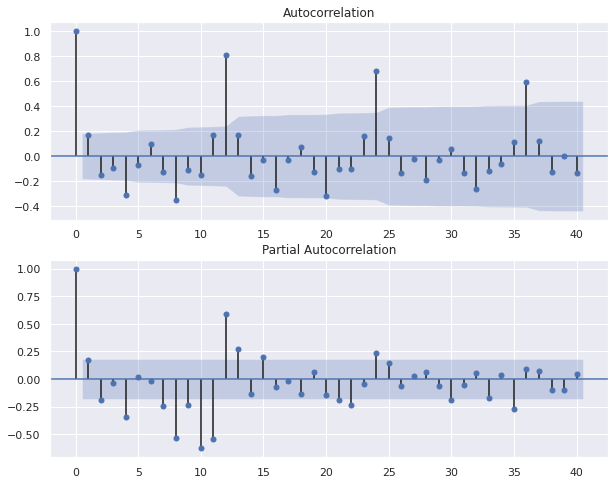

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(train_diff, lags=40, ax=plt.gca())
plt.subplot(212)
plot_pacf(train_diff, lags=40, ax=plt.gca(), method='ols')
plt.show()

Podemos apreciar que el primer valor significante en PACF es en lag 1, mientras que el primer valor significante en el ACF se da en el Lag 4, lo que sugiere que p=1  y q=4. Tambien se aprecia el componente estacional con un periodo S=12 en el ACF. Dado que el valor al lag S=12 en el ACF es positivo asumimos un valor P=1 y Q=0. Dado que el componente estacional es inestable con el tiempo asumimos un valor D=0. También asumiremos d=1, ya que estamos con una serie con tendencia aparentemente lineal.
Con ello, nuestro modelo Sarima seria:  SARIMA(1,1,4)(1,0,0)[12] . Abajo se muestra el codigo donde se hace el ajuste y la evaluacion de dicho modelo en Walk-forward. A modo de comparación se ajusta primero un modelo ARIMA(1,1,4).

In [ ]:
# Grid search del modelo ARIMA para el dataset airline-passengers
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")   # para evitar que muestre constantemente advertencias


# Evalua un modelo ARIMA en estrategia walk-forward para un orden dado (p,d,q) y fraccion de train
def evaluate_arima_model(X, arima_order, train_fraction):
    # prepare training dataset
    train_size = int(len(X) * train_fraction)
    train, test = X[0:train_size], X[train_size:]
    
    # hace las predicciones
    history = train.tolist()  # serie historica para ajustar el modelo. Inicialmente es train
    predictions = list()      # para almacenar las predicciones en test
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order) # crea el modelo ARIMA(p,d,q)
        model_fit = model.fit(disp=0)             # ajusta el modelo a los datos de history
        y_predicted = model_fit.forecast()[0]     # predice el siguiente punto despues de history
        predictions.append(y_predicted)
        history.append( test[t] ) 

    # calculate el RMSE en test
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse


# evalua de forma grid las combinaciones de p_values, d_values, q_values de un modelo ARIMA
def grid_model_evaluation(series, train_fraction, p_values, d_values, q_values):
    series = series.astype('float32')  # asegura que la serie sea numerica
    best_score, best_cfg = float("inf"), None
    # evaluacion grid
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(series, order, train_fraction)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('Modelo ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    print('Modelo ARIMA{} No se pudo ajustar'.format(order))
                    continue
    print('Mejor modelo: ARIMA%s, RMSE=%.3f' % (best_cfg, best_score))

    
    
# Valores de hiperparametros a evaluar
p_values = [0, 1, 2, 3, 4, 5, 6]
d_values =  [0, 1]
q_values =  [0, 1, 2, 3, 4, 5, 6]

train_fraction = 0.8

# realiza la evaluacion grid
grid_model_evaluation(X, train_fraction, p_values, d_values, q_values)

Modelo ARIMA(0, 0, 0) No se pudo ajustar
Modelo ARIMA(0, 0, 1) No se pudo ajustar
Modelo ARIMA(0, 0, 2) No se pudo ajustar
Modelo ARIMA(0, 0, 3) No se pudo ajustar
Modelo ARIMA(0, 0, 4) No se pudo ajustar
Modelo ARIMA(0, 0, 5) No se pudo ajustar
Modelo ARIMA(0, 0, 6) No se pudo ajustar
Modelo ARIMA(0, 1, 0) No se pudo ajustar
Modelo ARIMA(0, 1, 1) No se pudo ajustar
Modelo ARIMA(0, 1, 2) No se pudo ajustar
Modelo ARIMA(0, 1, 3) No se pudo ajustar
Modelo ARIMA(0, 1, 4) No se pudo ajustar
Modelo ARIMA(0, 1, 5) No se pudo ajustar


Ahora implementamos el modelo SARIMA(1,1,4)(1,0,0)[12] . Abajo se muestra el codigo donde se hace el ajuste y la evaluacion de dicho modelo en Walk-forward y se compara con un ARIMA(1,1,4)

In [ ]:
from sklearn.metrics import mean_squared_error   # para calcular el error cuadratico medio
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

history = train.tolist()  # serie historica para ajustar el modelo. Inicialmente es train
predictions_sarima = list() # para almacenar las predicciones en test del modelo sarima
predictions_arima = list() # para almacenar las predicciones en test  del modelo arima

# evaluación walk-forward
for t in range(len(test)):
    
    # Ajusta modelo Sarima y realiza one-step forecast
    sarimamodel = SARIMAX(history, order=(1,1,4), seasonal_order=(1,0,0,12), enforce_stationarity=False, enforce_invertibility=False)
    sarimamodel_fit = sarimamodel.fit(disp=0)  # ajusta el modelo con los datos de history
    sarima_forecast = sarimamodel_fit.forecast()[0]  # predice el siguiente punto despues de history
    predictions_sarima.append(sarima_forecast)
    
    # Ajusta modelo Arima y realiza one-step forecast
    arimamodel = ARIMA(history, order=(1,1,4))  # instancia un modelo ARIMA(1,1,4)
    arimamodel_fit = arimamodel.fit(disp=0)  # ajusta el modelo con los datos de history
    arima_forecast = arimamodel_fit.forecast()[0]  # predice el siguiente punto despues de history
    predictions_arima.append(arima_forecast)
    
    history.append( test[t] )  # añade a history la observación actual de test 

# evalua el RMSE del modelo SARIMA
rmse = sqrt(mean_squared_error(np.exp(test), np.exp(predictions_sarima)))
print('RMSE walk-forward en test de modelo SARIMA: %.3f' % rmse)
    
# evalua el RMSE del modelo ARIMA
rmse = sqrt(mean_squared_error(np.exp(test), np.exp(predictions_arima)))
print('RMSE walk-forward en test de modelo ARIMA: %.3f' % rmse)

# plotea las predicciones versus lo real
plt.plot(np.exp(test), color='black')
plt.plot(np.exp(predictions_arima), color='green')
plt.plot(np.exp(predictions_sarima), color='red')
plt.legend(['real', 'arima_prediccion', 'sarima_prediccion'],  loc='upper left')
plt.show()

## Buscando los hiperparámetros optimos de un modelo SARIMA con Busqueda Grid

Una forma de encontrar hiperparámetros óptimos para un modelo Sarima es realizar búsqueda grid. Los parámetros que definen un modelo Sarima en Python son los siguientes:

    * order (p,d,q): parámetros para modelar el componente de tendencia 
    * seasonal_order (P, D, Q)[S]: parámetros para modelar el componente estacional
    * trend: Parámetro para especificar la tendencia determinística. Puede asumir los siguientes valores: 'n','c','t','ct', que indican respectivamente: "no tendencia", "constante", "lineal", y "constante con tendencia lineal" 

Para hacer busqueda grid vamos a crear primero una funcion <b>evaluate_sarima_model</b> que encapsule el proceso de evaluacion del modelo, teniendo como entrada una serie temporal, la configuracion de hiperparametros SARIMA y la fraccion de la serie que será usada para train. Como salida se tiene el RMSE en walk-forward en la parte de test

In [ ]:
# Evalua un modelo SARIMA en estrategia walk-forward para una configuracion de parámetros y fraccion de train
def evaluate_sarima_model(X, config, train_fraction):
    
    # desempaqueta los parámetros de la configuración dada 
    order, sorder, trend = config   
    
    # prepara train/test data
    train_size = int(len(X) * train_fraction)
    train, test = X[0:train_size], X[train_size:]
    
    # Intenta ajustar y predecir el Modelo SARIMA con la configuración dada. Si da error se atrapa en except
    try:
        # hace las predicciones
        history = train.tolist()  # Inicializa serie historica para ajustar el modelo con data de train
        predictions = list()      # para almacenar las predicciones en test
        for t in range(len(test)):
            # define el modelo SARIMA(p,d,q)(P,D,Q)[S]
            model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False) 
            model_fit = model.fit(disp=0)             # ajusta el modelo a los datos de history
            y_predicted = model_fit.forecast()[0]     # predice el siguiente punto despues de history
            predictions.append(y_predicted)
            history.append( test[t] ) 
            
        # calculate el RMSE en test
        rmse = sqrt(mean_squared_error(test, predictions))   
        print(' SARIMA[%s] %.3f' % (str(config), rmse))
    except:
        rmse = None

    return (str(config), rmse) 

La función sarima_configurations() de abajo sirve para crear una lista de configuraciones de modelos SARIMA a evaluar. Se  asume valores bajos o desactivados (0) de los parámetros. Es posible modificar estos rangos si se piensa que el orden puede ser mayor. Se puede especificar una lista de períodos estacionales (por defecto es 0 (no componente estacional)). A pesar de ser una cantidad elevada de posibles modelos, en la práctica, muchas no serán válidas y darán como resultado un error que se atrapa e ignora en <b>evaluate_sarima_model()</b>

In [ ]:
# crea una lista de configuraciones de modelos Sarima para probar
def sarima_configurations(seasonal_periods=[0]):
    configs = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    S_params = seasonal_periods
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for S in S_params:
                                    cfg = [(p,d,q), (P,D,Q,S), t]
                                    configs.append(cfg)
    return configs

Probemos en el dataset <b>airline-passengers.csv</b> 

In [ ]:
# carga la serie  airline-passengers
series = pd.read_csv('airline-passengers.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

# saca logaritmo para tratar de hacer estacionaria la varianza de la serie
X = series.values
X = np.log(X)   
train_fraction = 0.8  # 80%  para entrenamiento

# obtiene la lista de configuraciones a probar 
config_list = sarima_configurations([0,12])

# hace la busqueda grid
scores = [ evaluate_sarima_model(X, config, train_fraction) for config in config_list ]

# remueve resultados vacios
scores = [r for r in scores if r[1] != None]

# ordena los resultados de mmenor a mayor rmse
scores.sort(key=lambda tup: tup[1])

# Imprime las top 3 configuraciones
for config, rmse in scores[:3]:
    print(config, rmse)

# VAR

Abajo se presenta un ejemplo de construcción de modelo VAR para el dataset <b>macrodata</b> provisto en statsmodels.api.   Dicho dataset tiene 14 variables económicas de USA a una resolución trimestral recolectadod por la FRED. Para este ejemplo se trabajará solo con 3 variables:

    * realgdp:   Producto interno bruto real de EEUU (Bil. USD encadenados de 2005, tasa anual desestacionalizada)
    * realcons:  Gastos reales de consumo personal  (Bil. USD encadenados de 2005, tasa anual desestacionalizada)
    * realinv:   Inversión interna privada bruta real (Bil. USD encadenados de 2005, tasa anual desestacionalizada)
    
Mayor informacion puede ser encontrada en https://www.statsmodels.org/dev/datasets/generated/macrodata.html


In [ ]:
# Librerias a usar
import numpy as np
import pandas
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

# Lee la data
mdata = sm.datasets.macrodata.load_pandas().data

# prepara el indice temporal
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)

# extrae las 3 variables que se trabajará y coloca el indice temporal
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)

# Retira la tendencia haciendo diferencias y aplica transformacion logaritmica para estacionarizar la varianza 
data = np.log(mdata).diff().dropna()

# Instancia el modelo VAR
model = VAR(data)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)


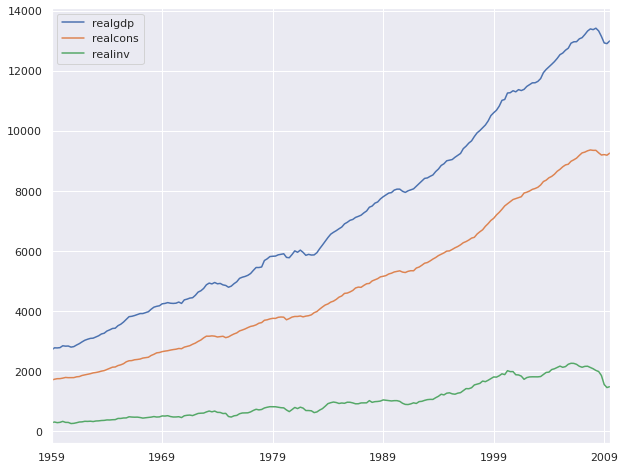

In [ ]:
# plotea las variables originales (sin transformar)
mdata.plot()
plt.show()

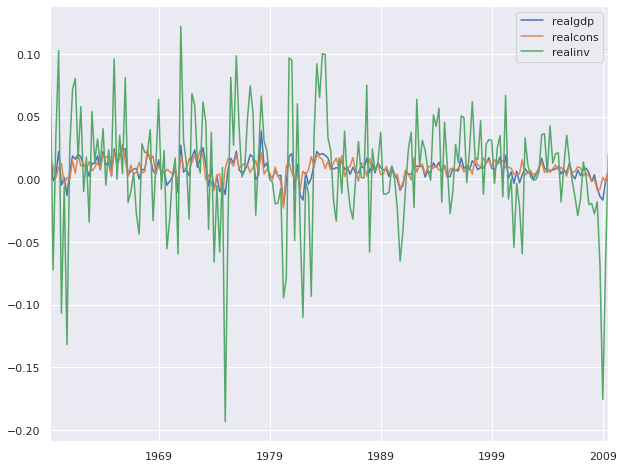

In [ ]:
# Plotea la data transformada (sin tendencias y estacionarizada en varianza)
data.plot()
plt.show()

In [ ]:
# Computa varios VAR  (hasta 10 lags) e informa las configuraciones con mejores valores de criterios de Informacion  
print(model.select_order(10))

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC -> 1>


In [ ]:
# Ajusta un modelo VAR con p=1 (fue el lag con mejores criterios AIC, BIC)
model_fit = model.fit(1)

In [ ]:
# Sumariza el modelo ajustado
model_fit.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 16, Sep, 2020
Time:                     20:23:15
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.7388
Nobs:                     201.000    HQIC:                  -27.8562
Log likelihood:           1963.94    FPE:                7.37174e-13
AIC:                     -27.9360    Det(Omega_mle):     6.94859e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.003580         0.000911            3.928           0.000
L1.realgdp         -0.338056         0.172084           -1.964           0.049
L1.realcons         0.746283         0.130411            5.723    

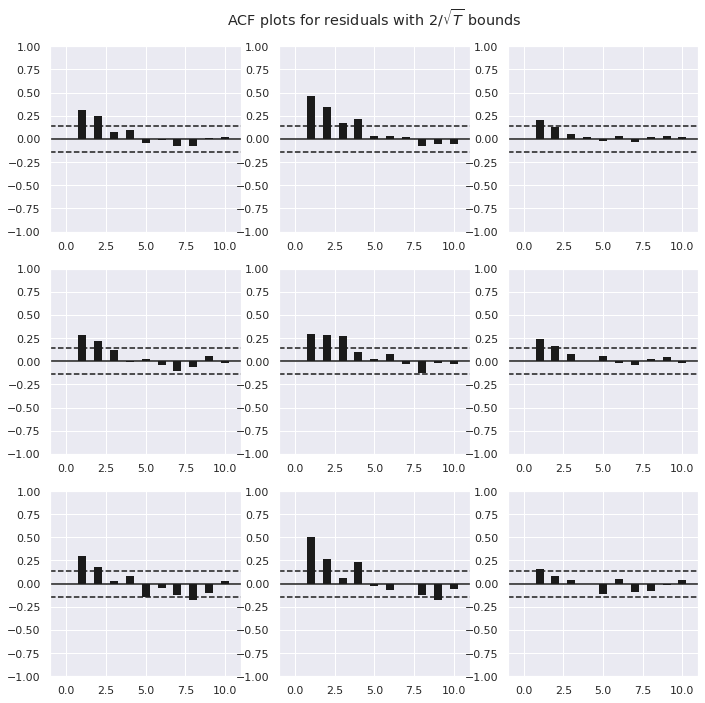

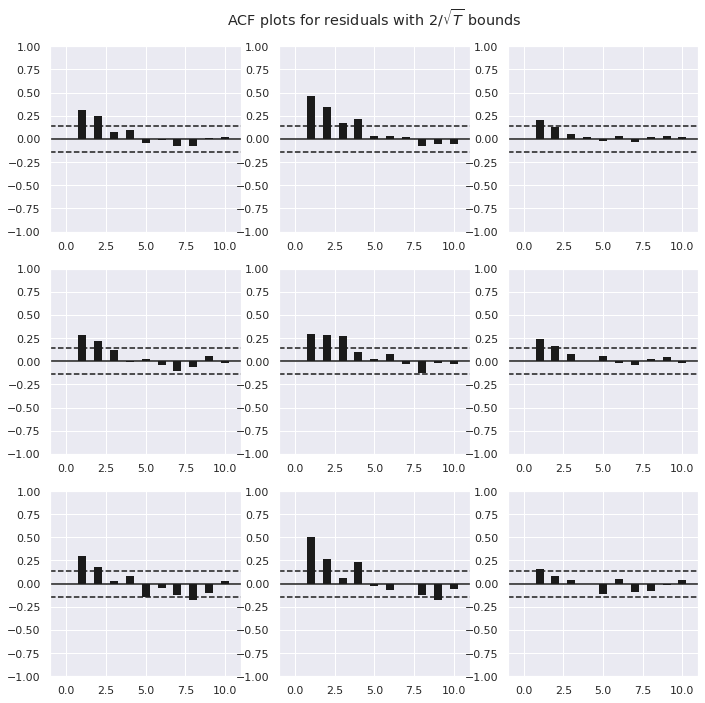

In [ ]:
# Plotea autocorrelación y crosscorrelacion de los residuos (para ver si vale la pena un VARMA) 
model_fit.plot_acorr(resid=False)

In [ ]:
# predice el siguiente punto temporal en las 3 variables (hay que proporcionarle la data histórica y el numero de steps)
y_predicted = model_fit.forecast(data.values[-50:], 1)

In [ ]:
y_predicted

array([[0.00785158, 0.00860589, 0.00834729]])

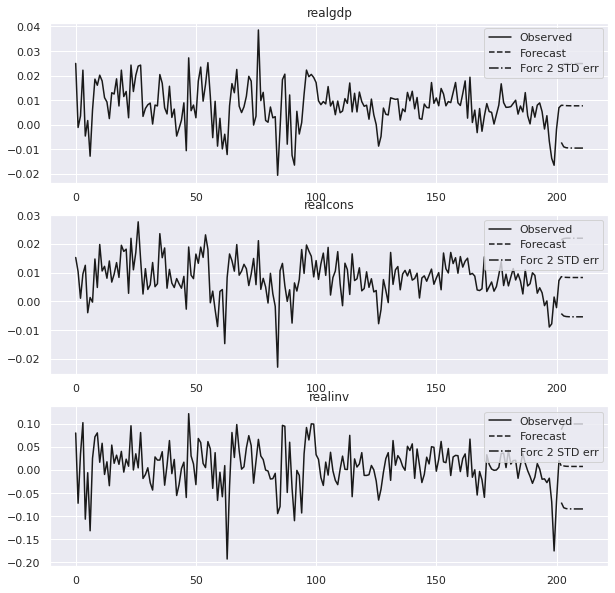

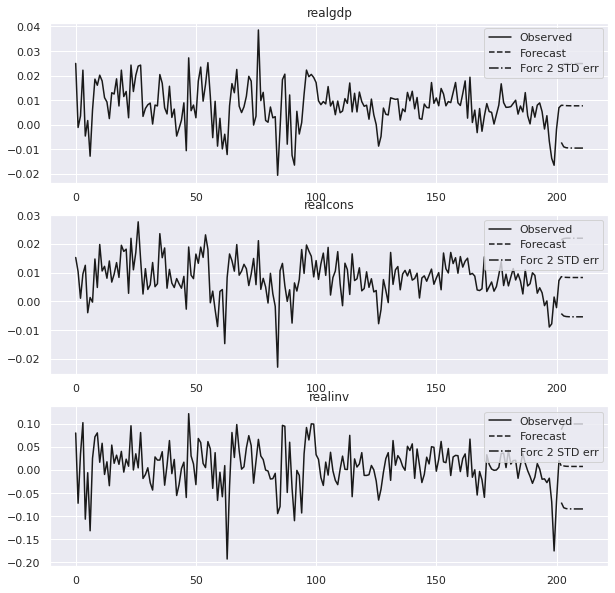

In [ ]:
# predice los siguientes 50 puntos (es predicción encadenada, no es walk-forwad ) 
model_fit.plot_forecast(10)

### Desafio

- Implementar la evaluacion en walk-forward del modelo VAR en el dataset <b>macrodata</b>  usando los 50 ultimos puntos como test. Calcular el rmse de cada variable
- Comparar con modelos AR ajustados individualmente en cada una de las variables individualmente 
    
